In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from network import DDRNet
import numpy as np
from dataset import RotatedDataset

db = RotatedDataset()

In [3]:
imgs, labels = db.generate_batch(n=1)

In [4]:
imgs_c = np.moveaxis(imgs, -1, 1).astype(np.float32)
labels_c = labels.reshape(labels.shape[0],1,8).astype(np.float32)

In [5]:
print(imgs_c.shape, labels_c.shape)

((1, 3, 320, 320), (1, 1, 8))


In [6]:
net = DDRNet()

# Optimizer
# optimizer =MomentumSGD(lr= 0.05)
#optimizer = Adam(alpha= 0.0001)
#optimizer.setup(net)

# Move network to gpu

In [7]:
net(imgs_c)[0].shape

(1, 1, 80, 80)

In [8]:
from functions import *

In [9]:
labels

array([[[[ 100.,  100.],
         [ 200.,  100.],
         [ 200.,  200.],
         [ 100.,  200.]]]])

In [10]:
# Cool now let's try encoding all channels. We will not let the pigeonhole principle win.

In [11]:
imgs_down, labels_down = downsample(imgs_c, labels_c)
gt_class, gt_loc = encode_y(imgs_down, labels_down) #cpu

#db.visualize_batch(imgs, labels)

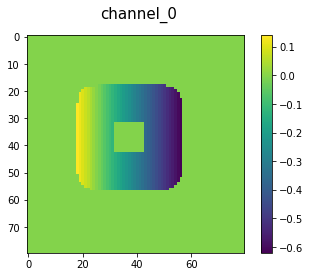

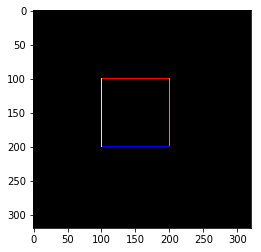

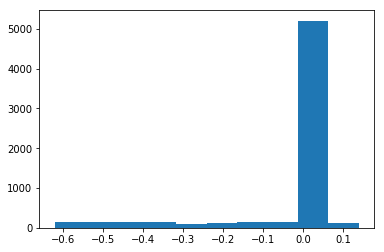

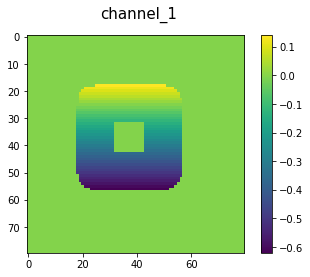

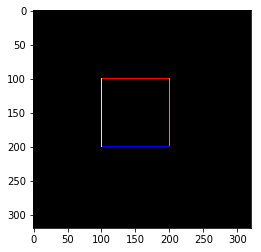

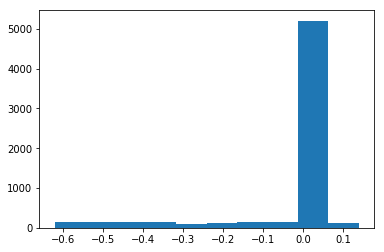

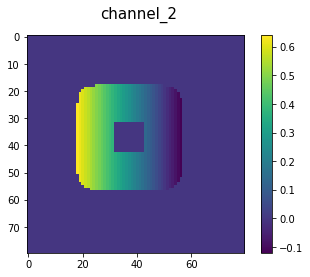

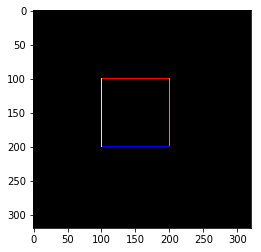

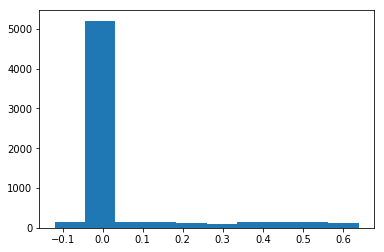

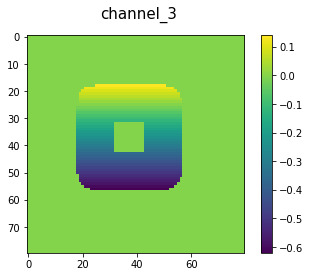

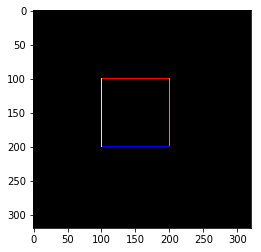

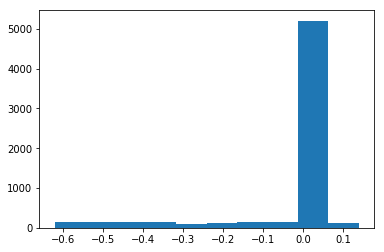

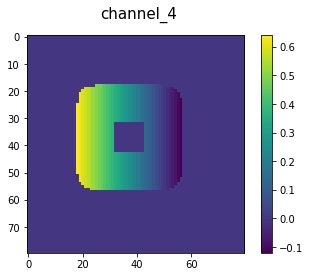

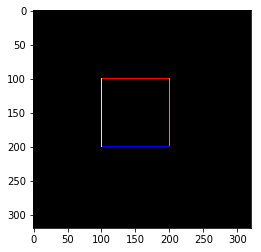

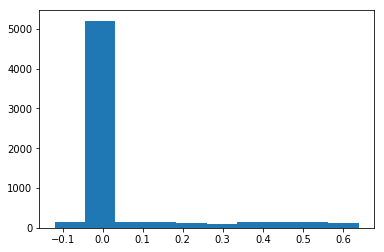

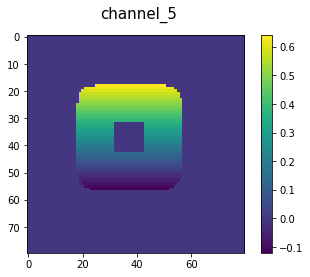

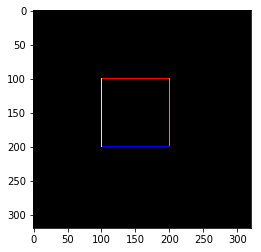

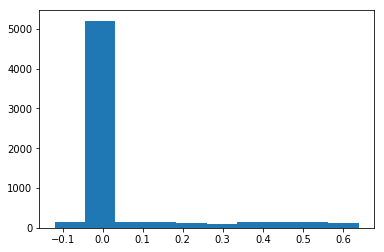

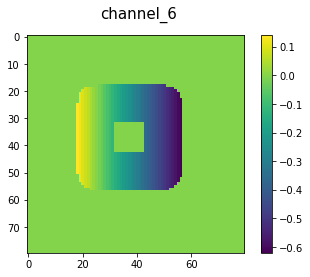

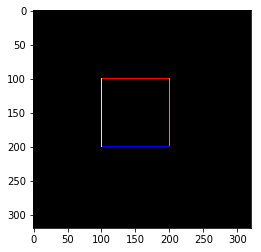

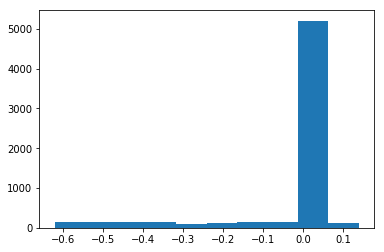

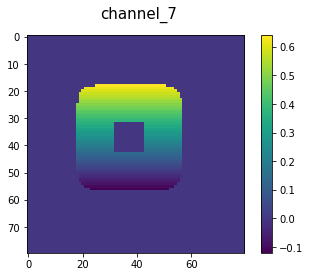

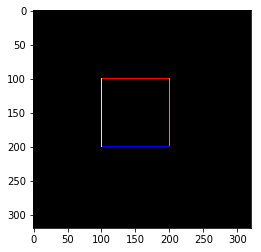

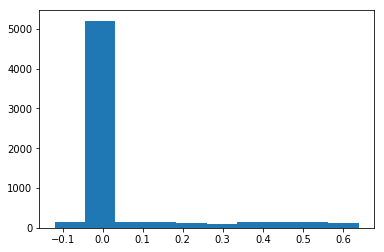

In [12]:
import matplotlib.pyplot as plt
from functions import draw_quad
for c in range(8):
    fig = plt.figure()
    fig.suptitle('channel_%d'%c, fontsize=15)

    img = gt_loc[0,c,:,:].data
    img_c = np.zeros((320,320,3), dtype=np.uint8)
    
    plt.imshow(img, interpolation=None); plt.colorbar(); plt.show()
    
    draw_quad(img_c, labels[0][0].astype(np.uint64))
    plt.imshow(img_c); plt.show()
    
    plt.hist(img.ravel()); plt.show()

In [13]:
labels[0].shape

(1, 4, 2)

In [14]:
# something is wrong with encoding?

In [15]:
imgs_down, labels_down = downsample(imgs_c, labels_c)

In [16]:
db.visualize_batch

<bound method RotatedDataset.visualize_batch of <dataset.RotatedDataset instance at 0x7f7f6a7d5440>>

In [17]:
from chainer.optimizers import MomentumSGD,Adam 

In [18]:
from network import VGGNet

net = VGGNet()
net.to_gpu(0)

#Ok now let's start the training process
#optimizer =MomentumSGD(lr= 0.0001)
optimizer=Adam(alpha= 0.0001)
optimizer.setup(net)

  0%|          | 0/1000 [00:00<?, ?it/s]

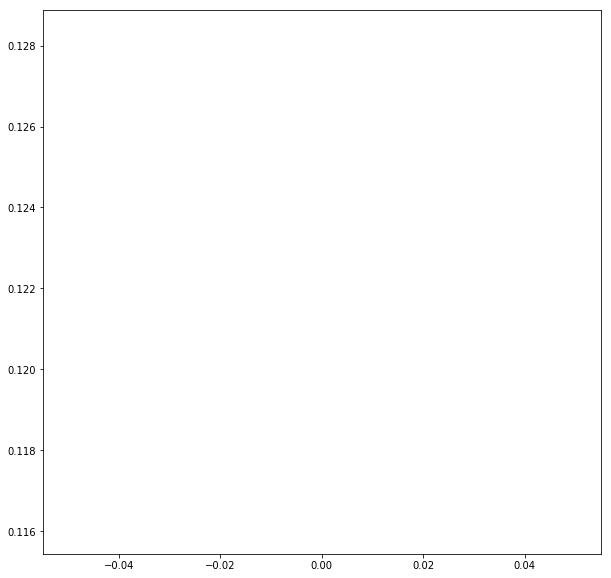

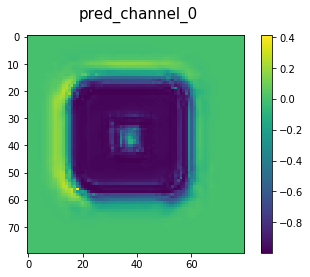

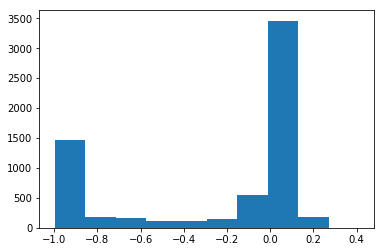

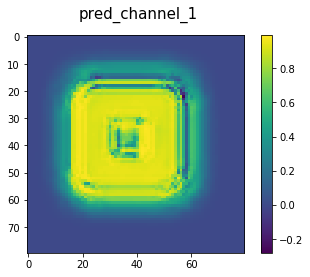

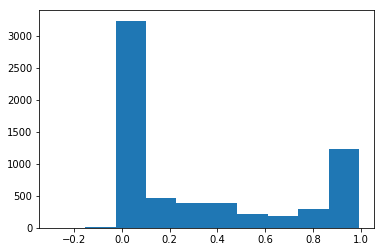

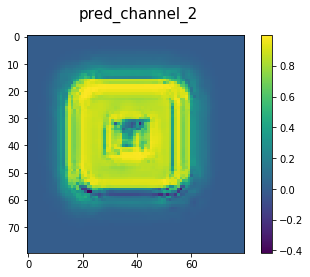

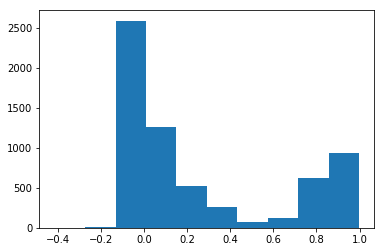

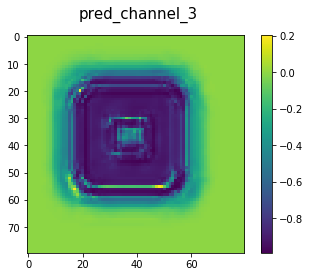

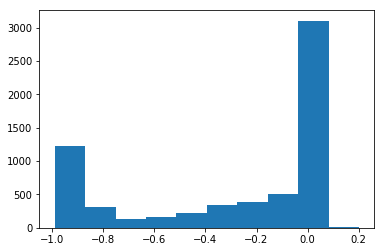

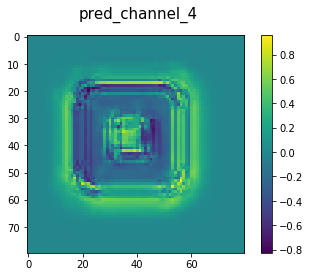

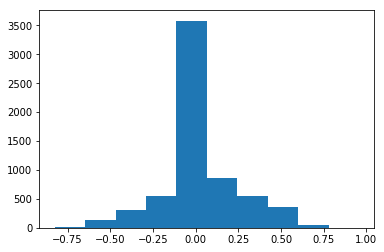

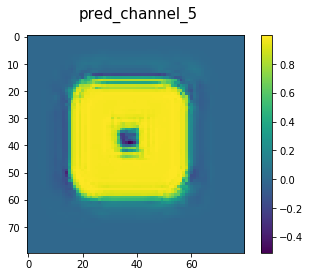

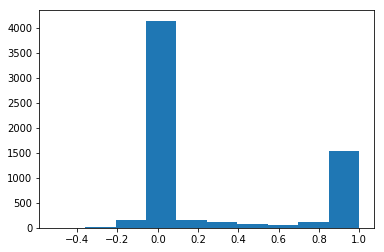

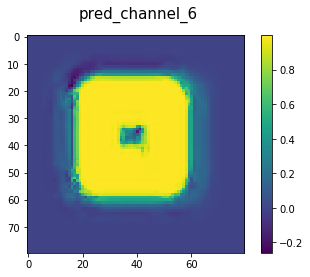

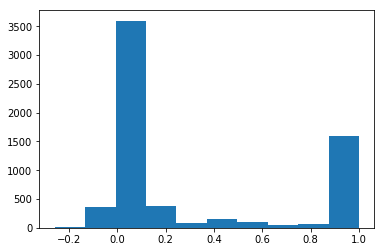

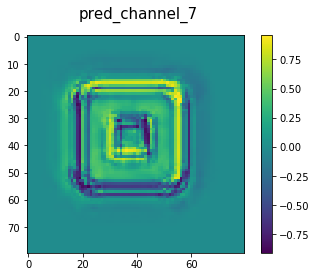

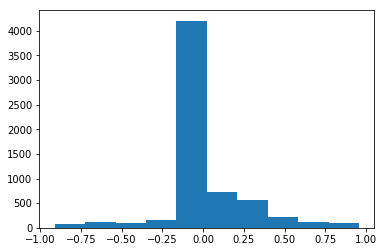

  1%|          | 10/1000 [00:06<07:36,  2.17it/s]

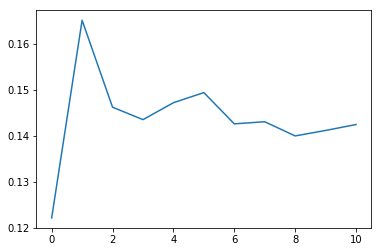

  2%|▏         | 20/1000 [00:09<05:30,  2.96it/s]

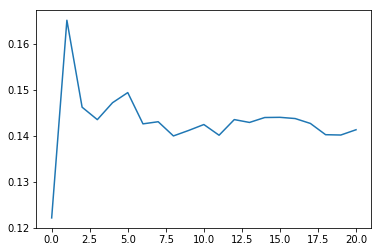

  3%|▎         | 30/1000 [00:13<05:29,  2.94it/s]

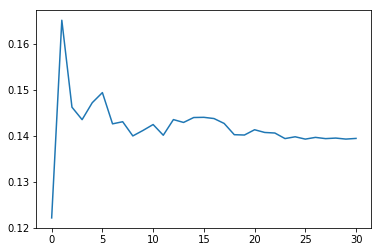

  4%|▍         | 40/1000 [00:17<05:22,  2.98it/s]

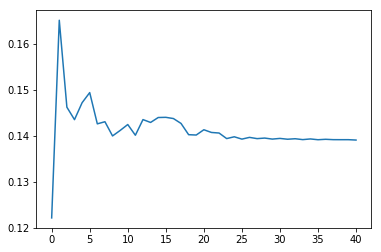

  5%|▌         | 50/1000 [00:20<05:42,  2.78it/s]

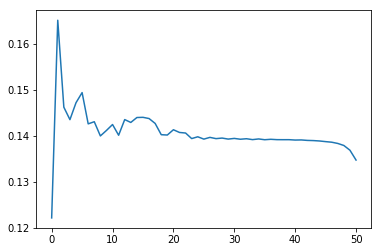

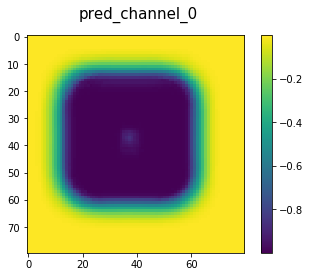

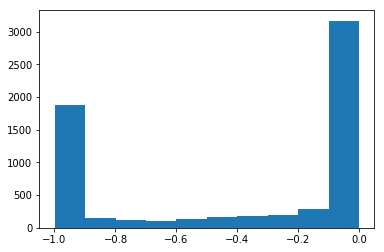

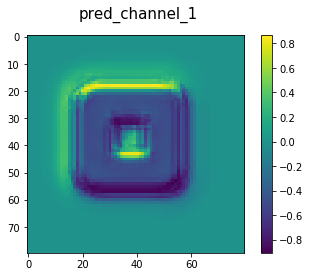

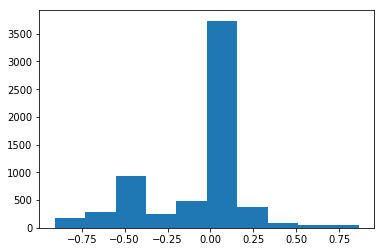

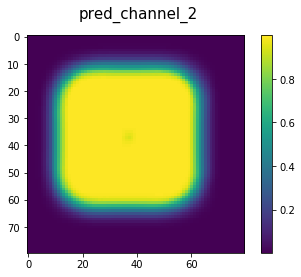

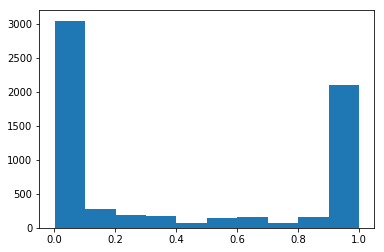

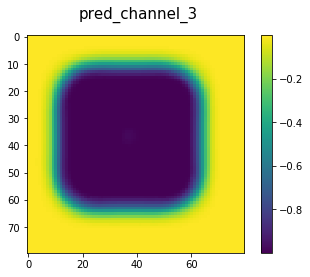

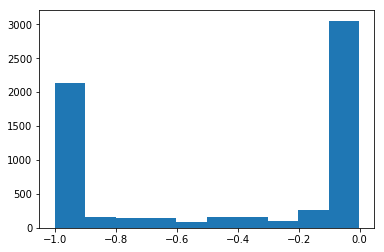

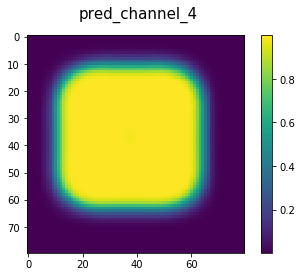

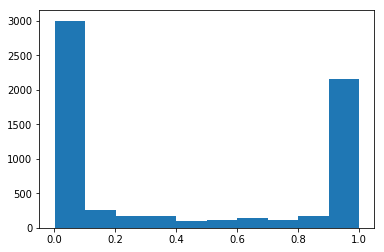

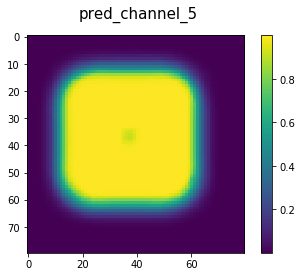

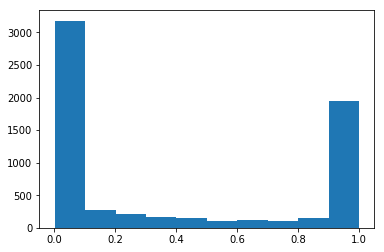

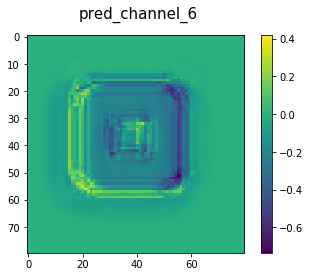

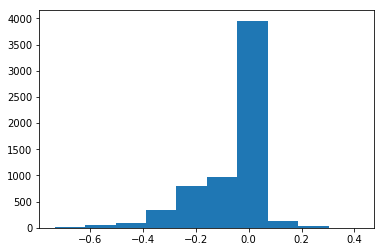

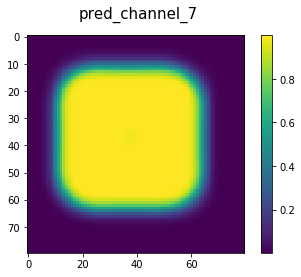

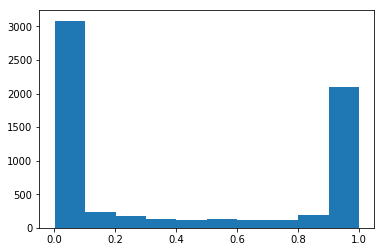

  6%|▌         | 60/1000 [00:26<05:44,  2.73it/s]

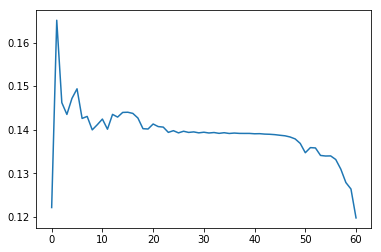

  7%|▋         | 70/1000 [00:29<05:14,  2.95it/s]

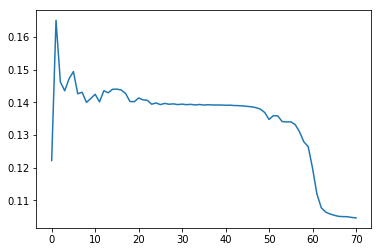

  8%|▊         | 80/1000 [00:33<05:10,  2.97it/s]

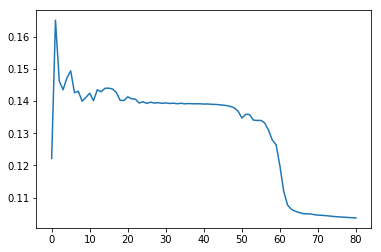

  9%|▉         | 90/1000 [00:36<05:04,  2.99it/s]

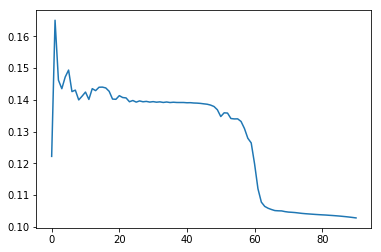

 10%|█         | 100/1000 [00:40<05:03,  2.96it/s]

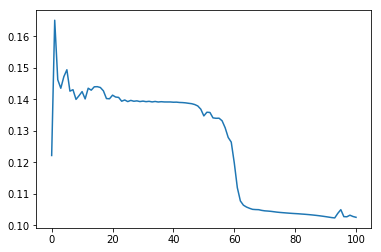

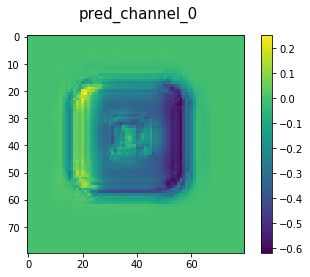

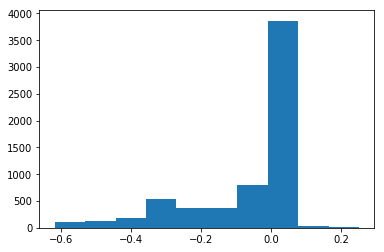

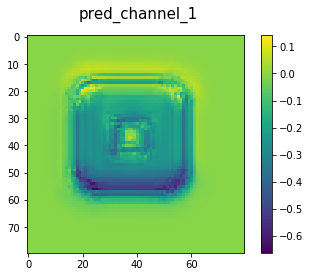

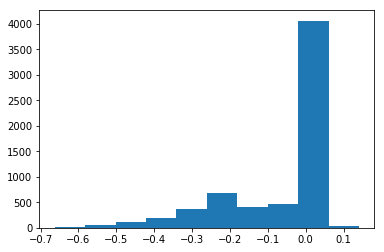

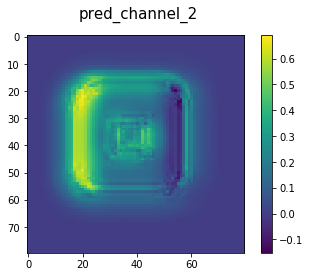

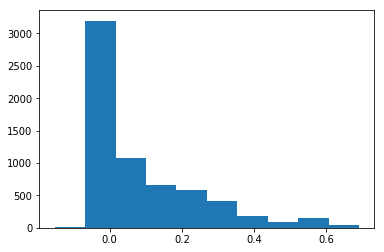

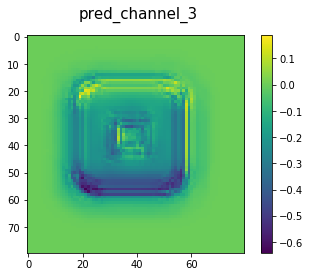

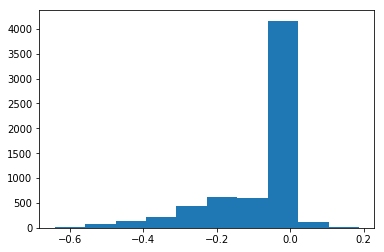

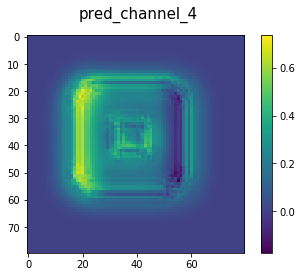

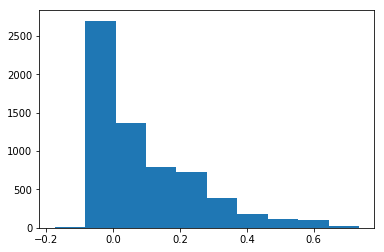

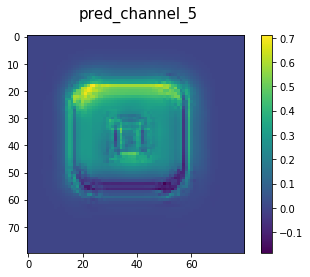

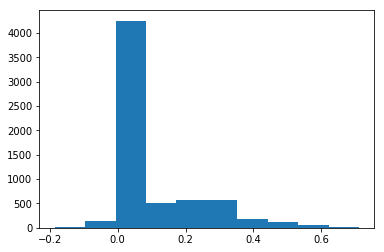

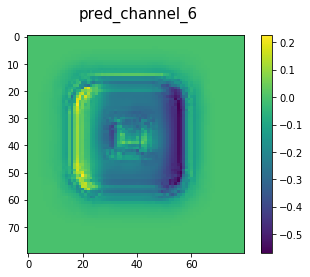

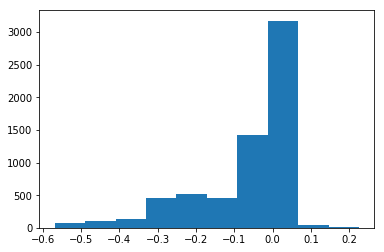

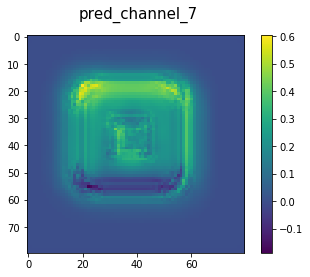

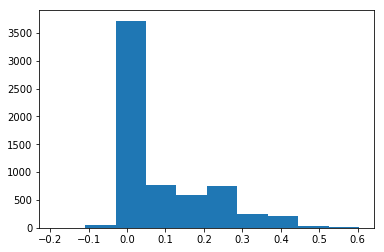

 11%|█         | 110/1000 [00:46<05:23,  2.75it/s]

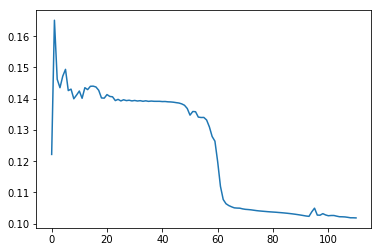

 12%|█▏        | 120/1000 [00:49<04:54,  2.99it/s]

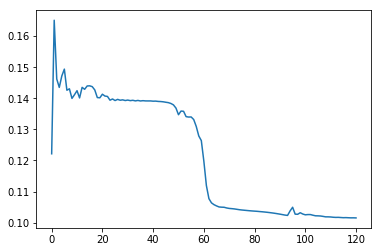

 13%|█▎        | 130/1000 [00:53<05:27,  2.65it/s]

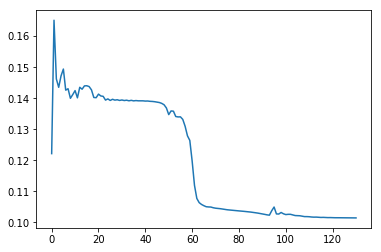

 14%|█▍        | 140/1000 [00:56<04:49,  2.97it/s]

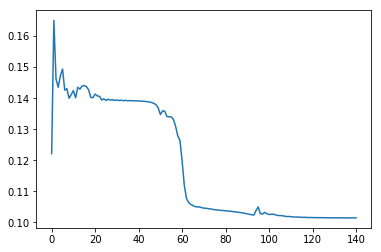

 15%|█▌        | 150/1000 [01:00<04:45,  2.98it/s]

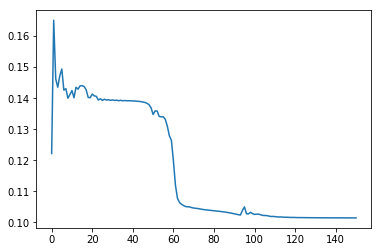

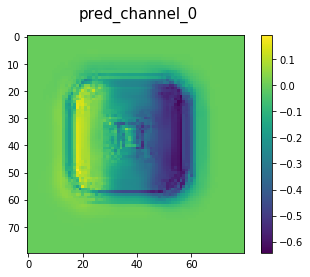

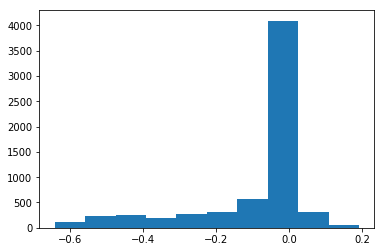

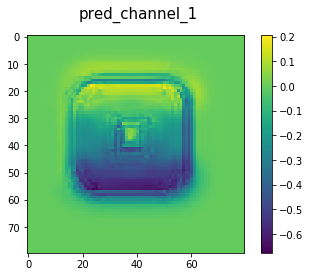

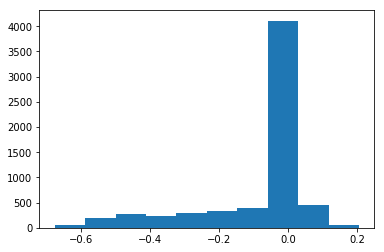

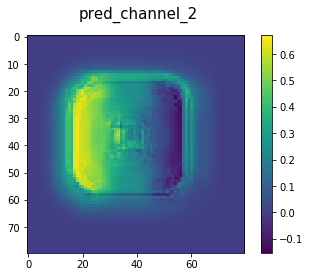

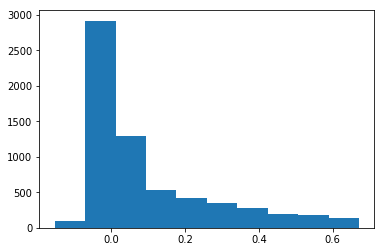

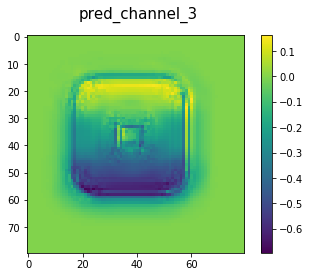

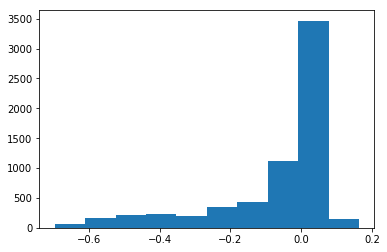

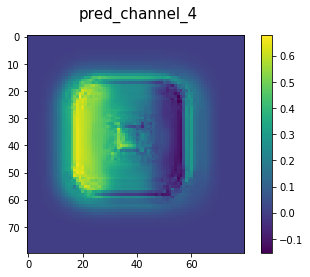

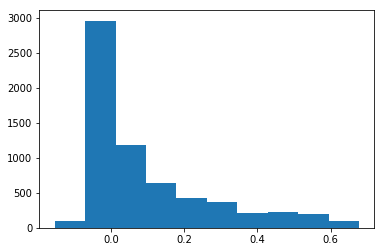

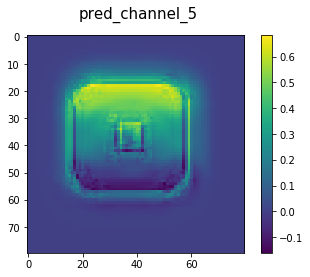

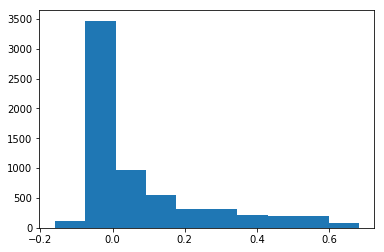

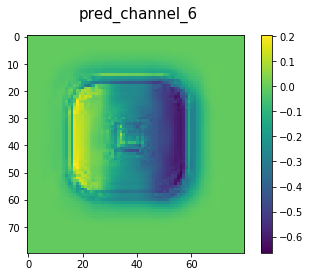

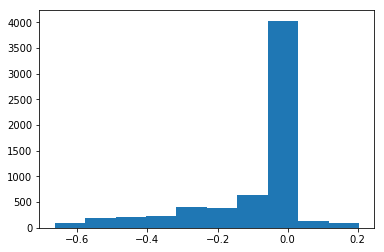

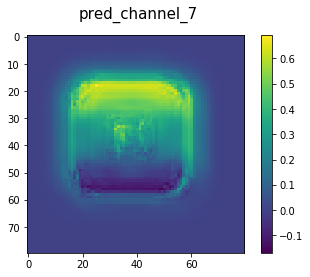

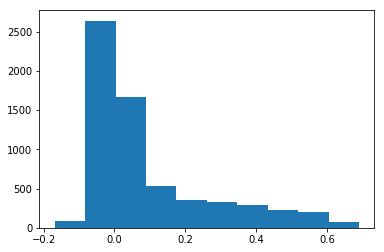

 16%|█▌        | 160/1000 [01:05<05:04,  2.75it/s]

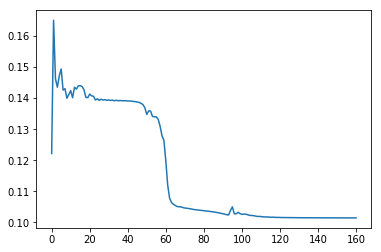

 17%|█▋        | 170/1000 [01:09<04:38,  2.98it/s]

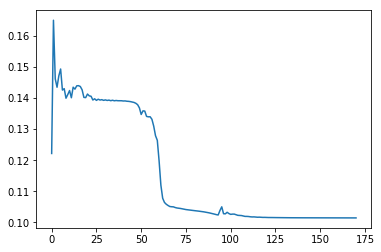

 18%|█▊        | 180/1000 [01:12<04:35,  2.98it/s]

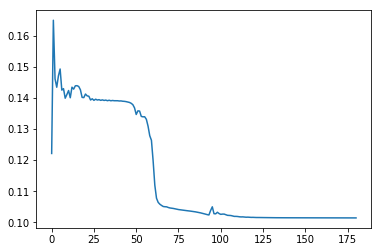

 19%|█▉        | 190/1000 [01:16<04:32,  2.97it/s]

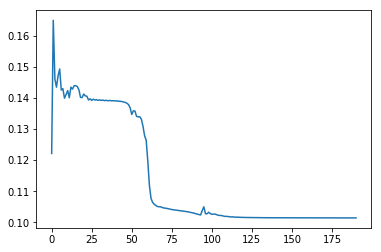

 20%|██        | 200/1000 [01:19<04:26,  3.00it/s]

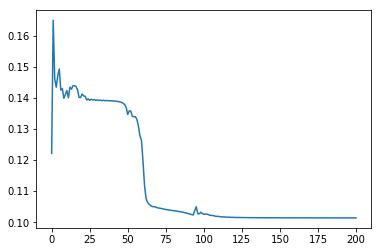

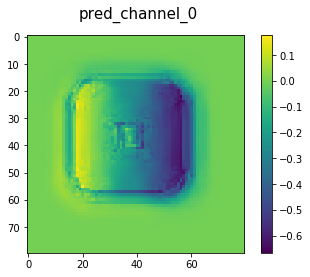

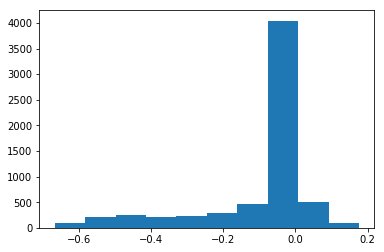

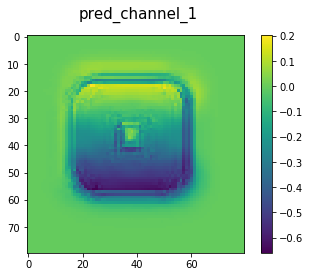

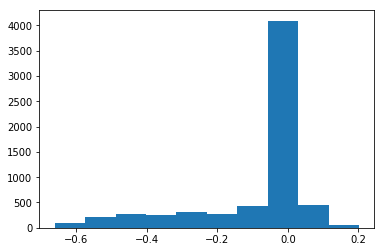

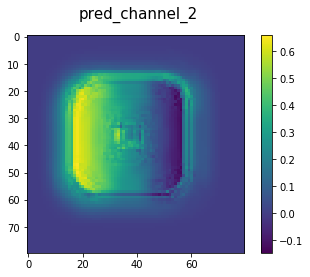

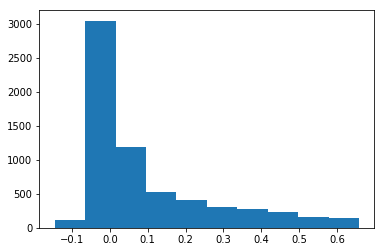

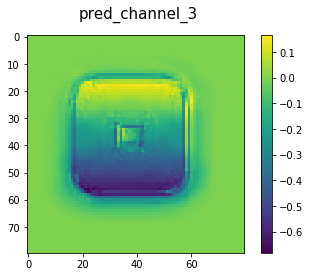

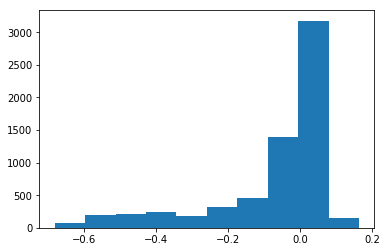

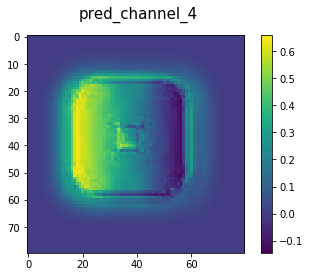

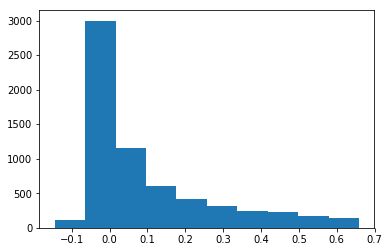

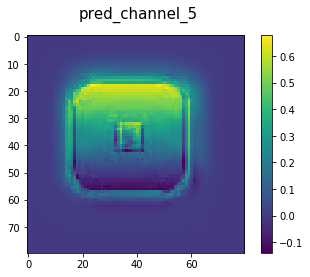

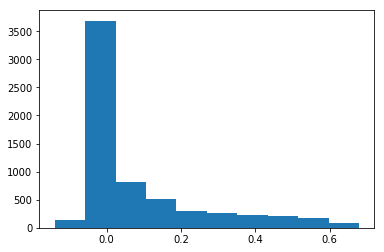

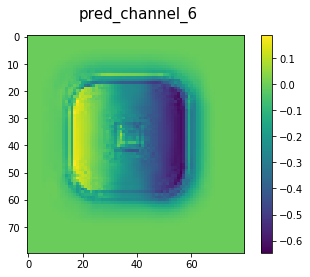

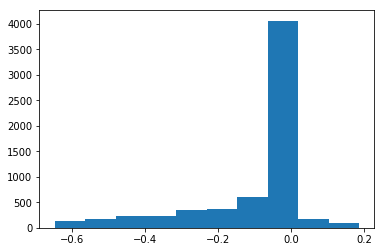

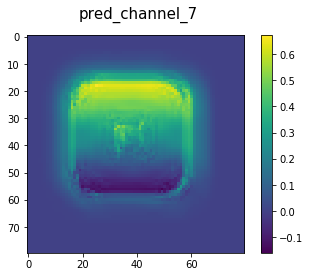

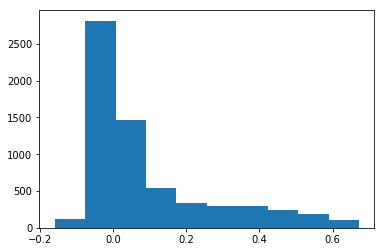

 21%|██        | 210/1000 [01:25<04:44,  2.78it/s]

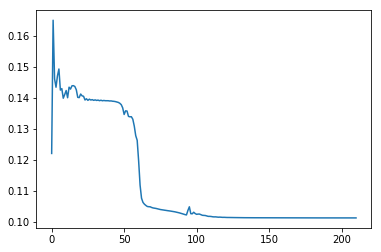

 22%|██▏       | 220/1000 [01:28<04:20,  2.99it/s]

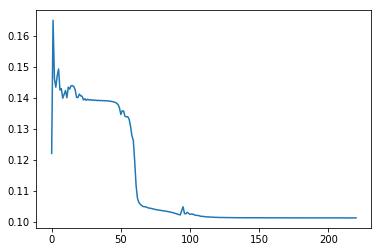

 23%|██▎       | 230/1000 [01:32<04:17,  2.99it/s]

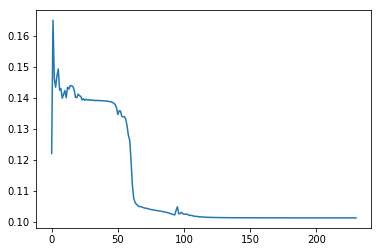

 24%|██▍       | 240/1000 [01:35<04:12,  3.01it/s]

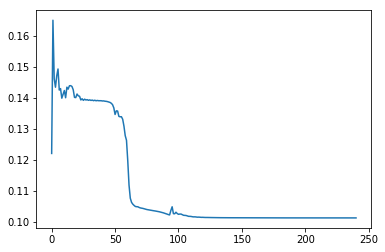

 25%|██▌       | 250/1000 [01:39<04:10,  2.99it/s]

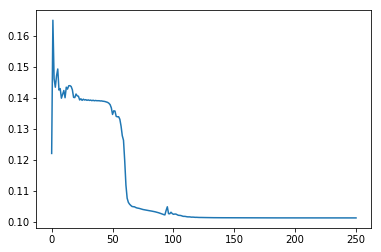

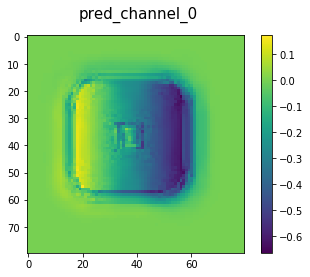

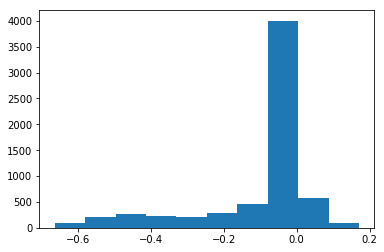

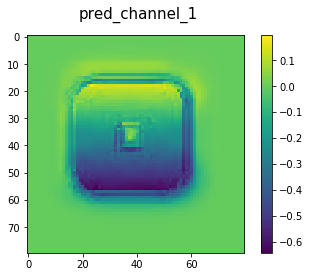

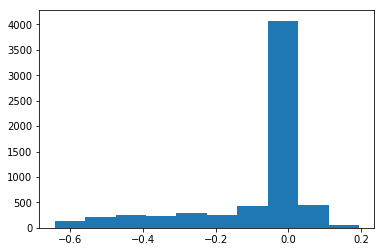

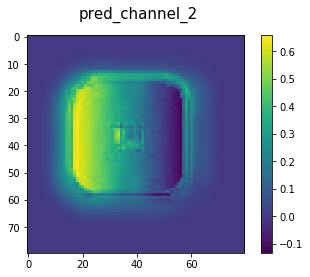

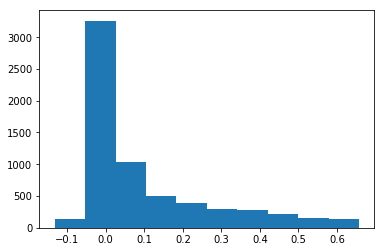

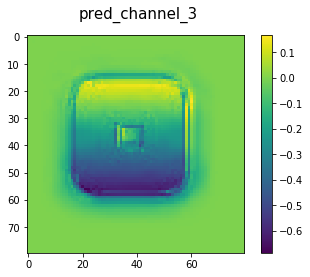

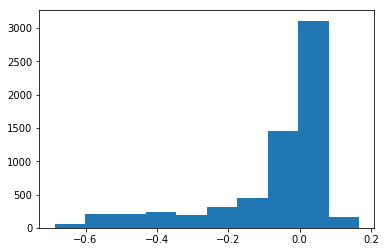

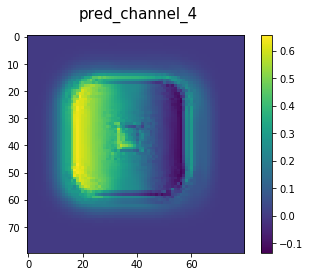

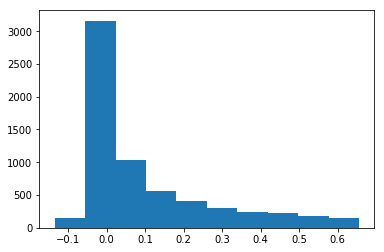

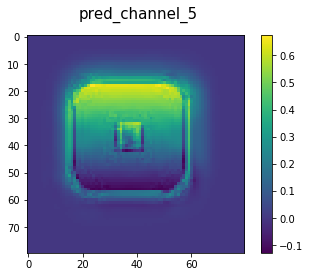

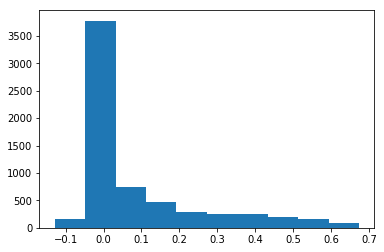

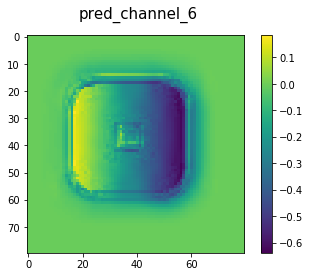

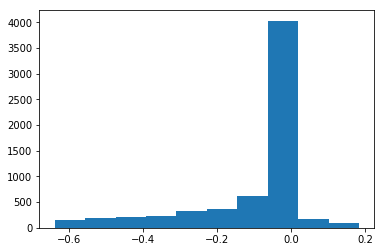

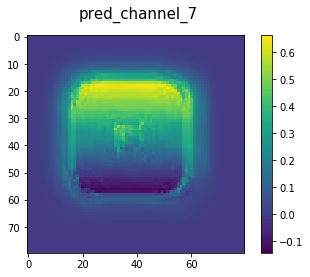

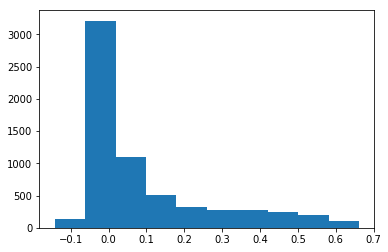

 26%|██▌       | 260/1000 [01:44<04:27,  2.77it/s]

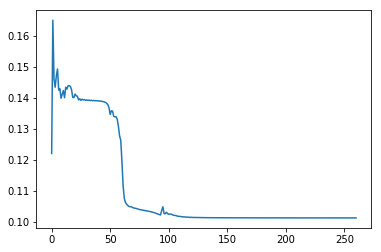

 27%|██▋       | 270/1000 [01:48<04:04,  2.99it/s]

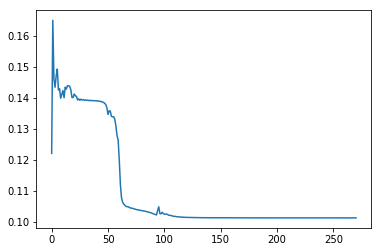

 28%|██▊       | 280/1000 [01:51<04:00,  3.00it/s]

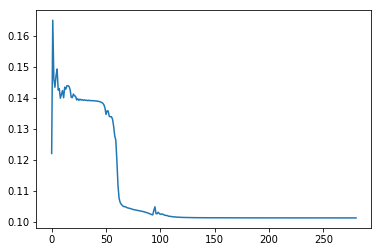

 29%|██▉       | 290/1000 [01:55<03:56,  3.01it/s]

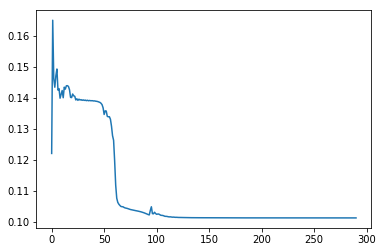

 30%|███       | 300/1000 [01:58<03:54,  2.98it/s]

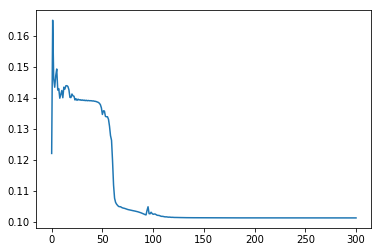

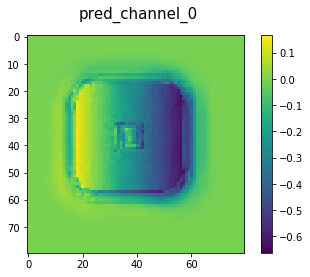

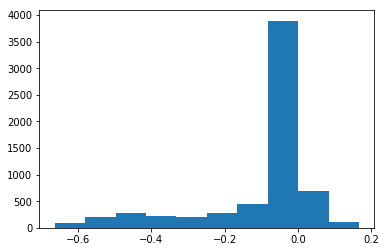

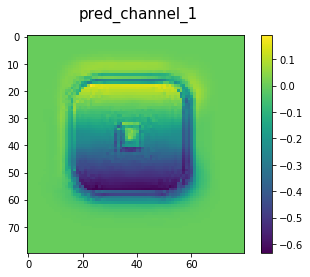

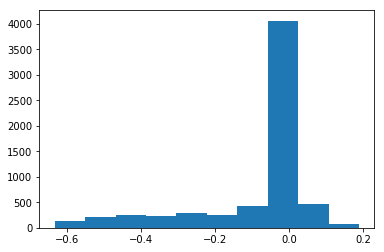

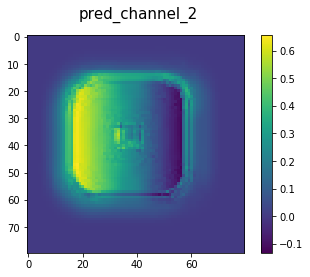

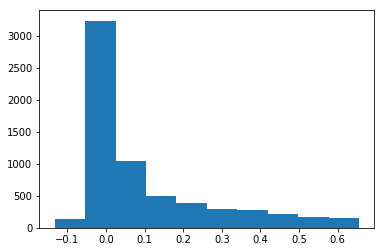

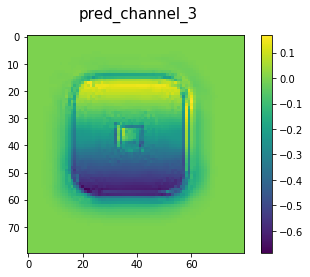

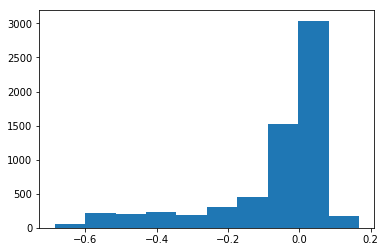

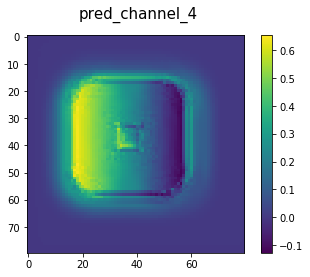

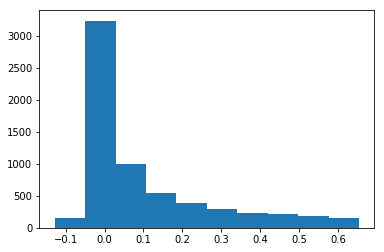

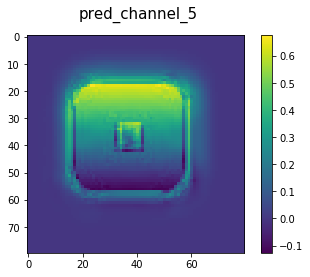

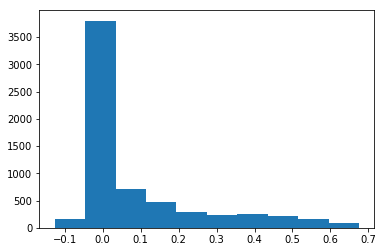

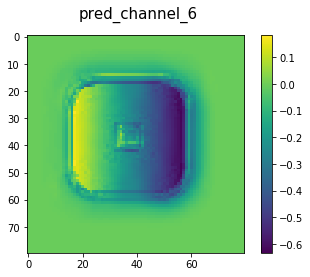

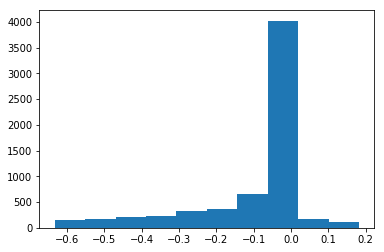

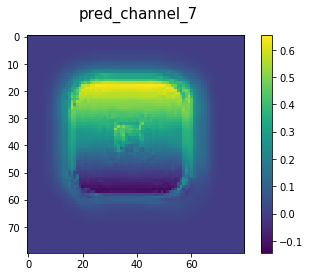

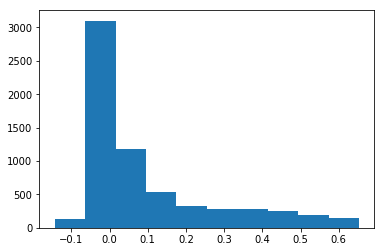

 31%|███       | 310/1000 [02:04<04:10,  2.76it/s]

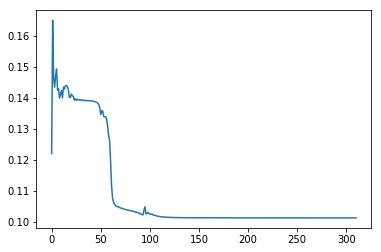

 32%|███▏      | 320/1000 [02:07<03:47,  2.99it/s]

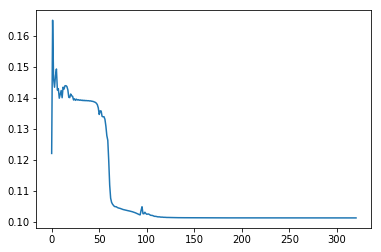

 33%|███▎      | 330/1000 [02:11<03:43,  3.00it/s]

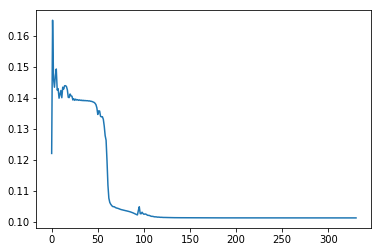

 34%|███▍      | 340/1000 [02:14<03:40,  2.99it/s]

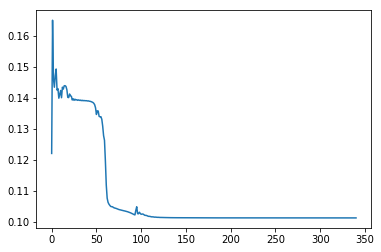

 35%|███▌      | 350/1000 [02:18<03:37,  2.99it/s]

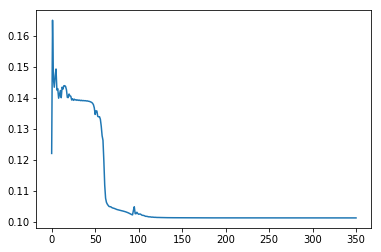

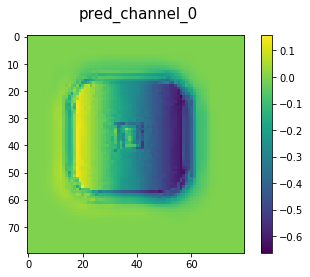

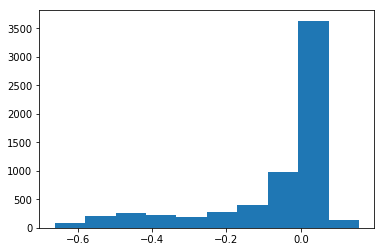

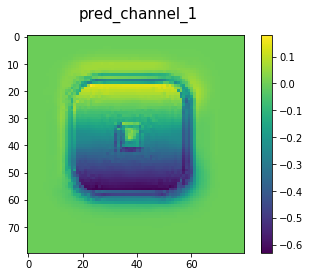

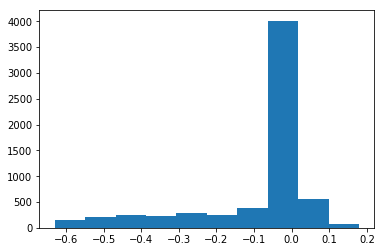

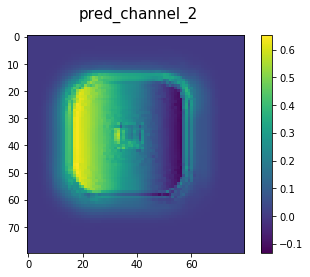

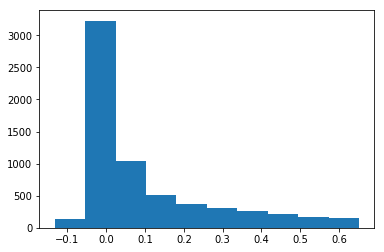

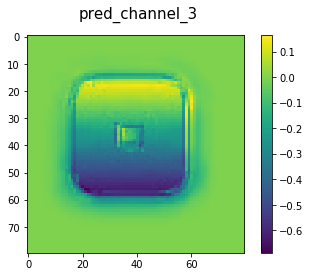

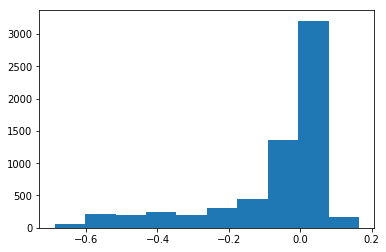

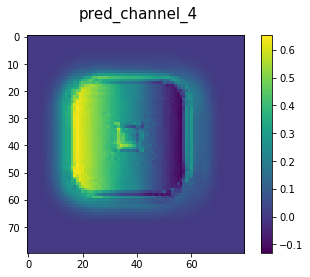

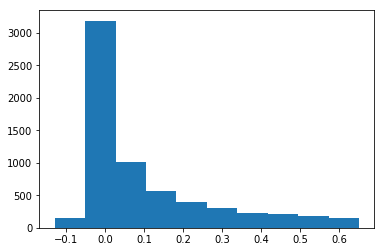

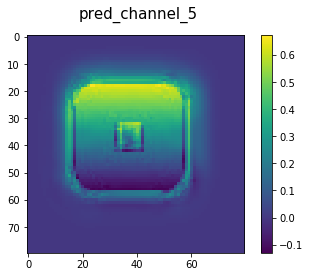

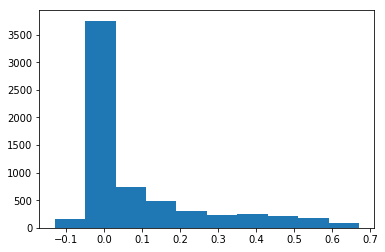

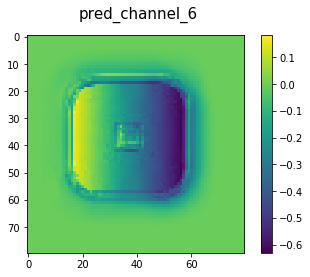

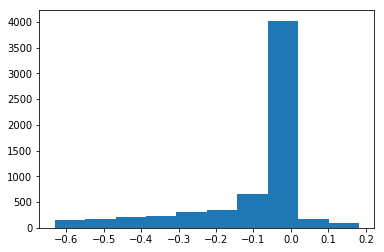

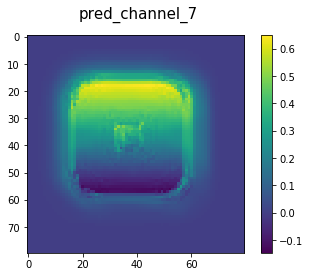

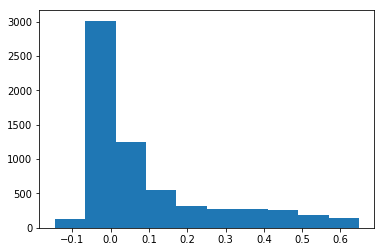

 36%|███▌      | 360/1000 [02:23<03:52,  2.75it/s]

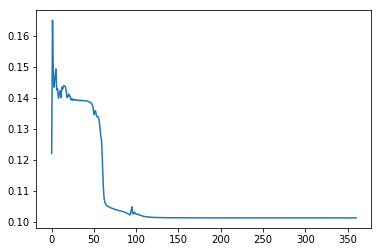

 37%|███▋      | 370/1000 [02:27<03:31,  2.98it/s]

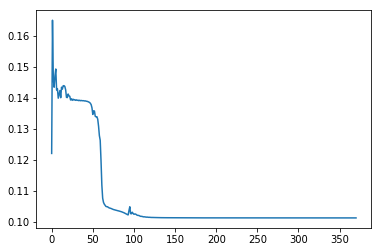

 38%|███▊      | 380/1000 [02:30<03:27,  2.99it/s]

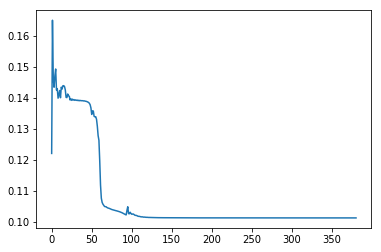

 39%|███▉      | 390/1000 [02:34<03:24,  2.99it/s]

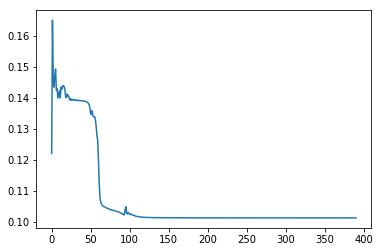

 40%|████      | 400/1000 [02:37<03:20,  3.00it/s]

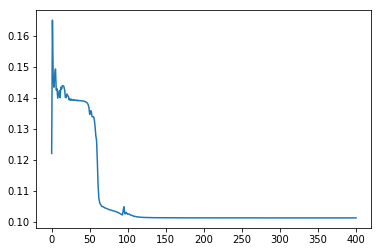

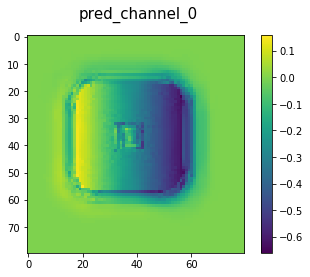

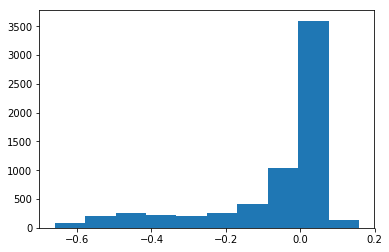

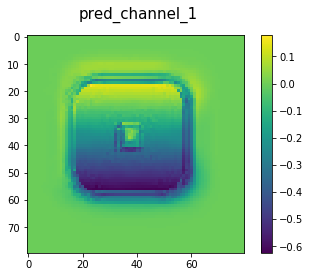

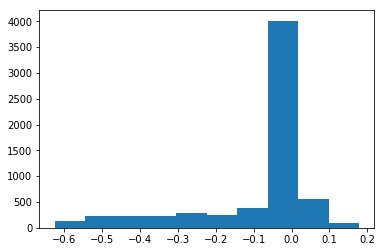

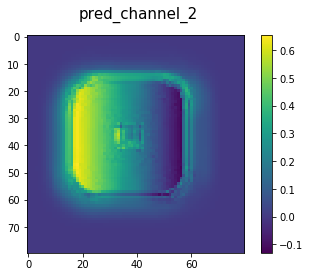

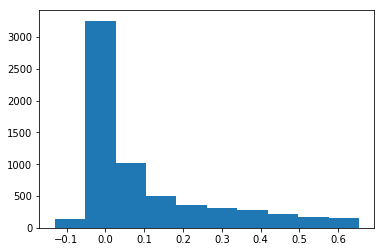

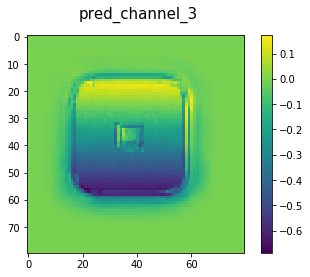

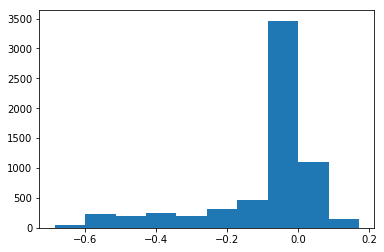

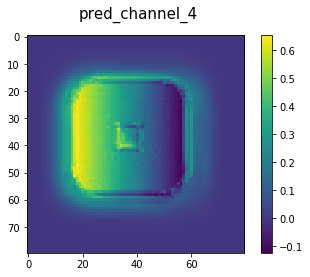

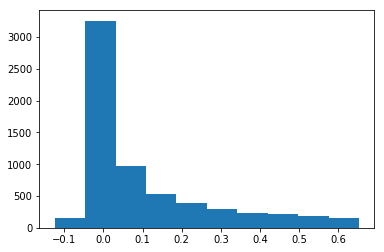

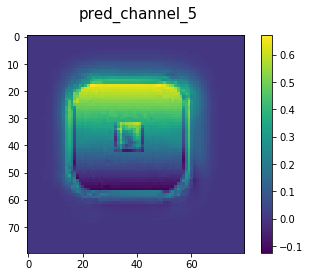

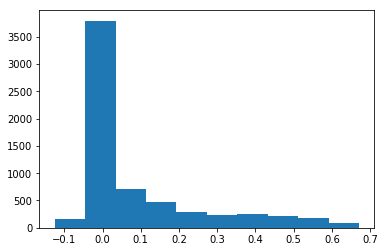

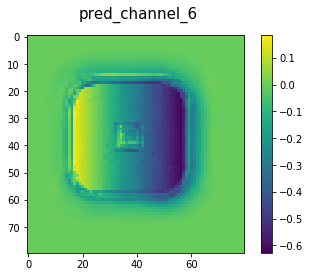

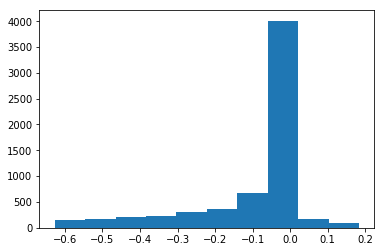

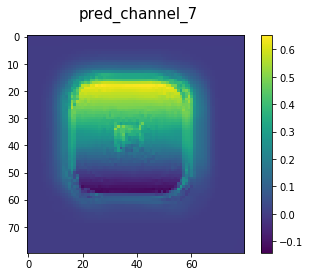

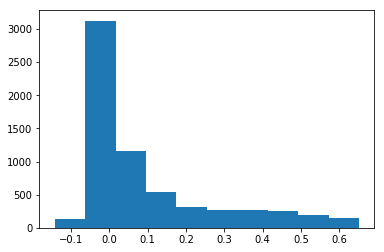

 41%|████      | 410/1000 [02:43<03:34,  2.75it/s]

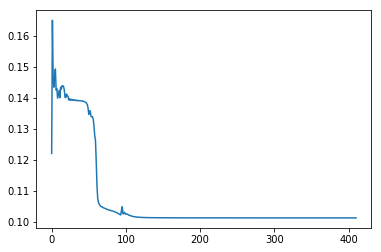

 42%|████▏     | 420/1000 [02:46<03:13,  2.99it/s]

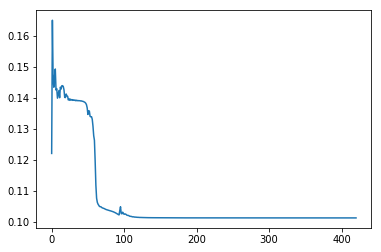

 43%|████▎     | 430/1000 [02:50<03:10,  2.98it/s]

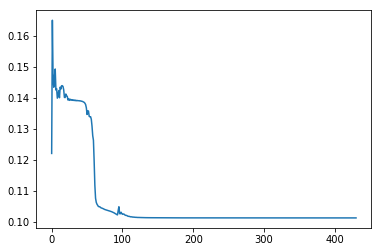

 44%|████▍     | 440/1000 [02:53<03:07,  2.99it/s]

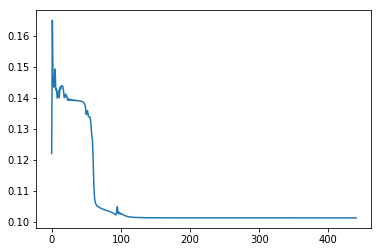

 45%|████▌     | 450/1000 [02:57<03:05,  2.97it/s]

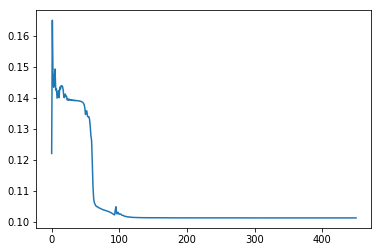

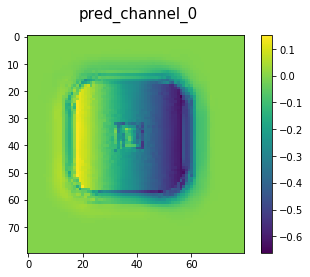

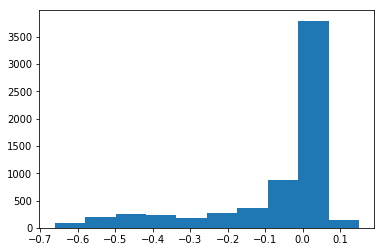

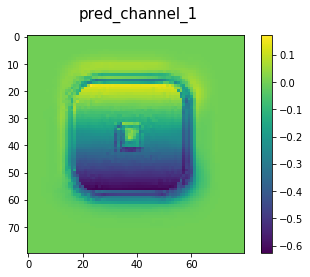

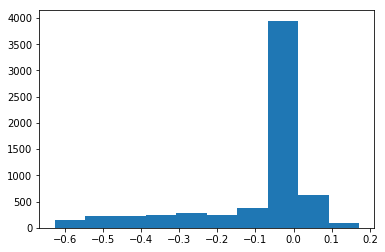

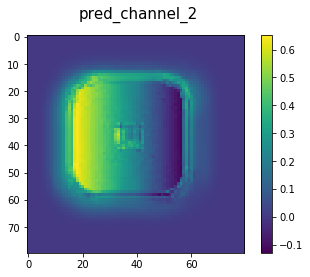

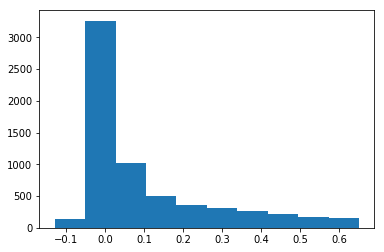

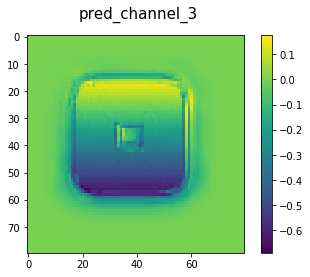

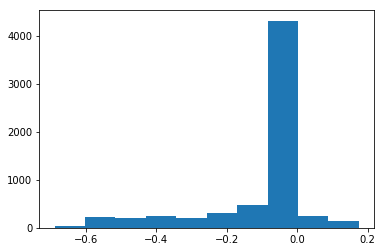

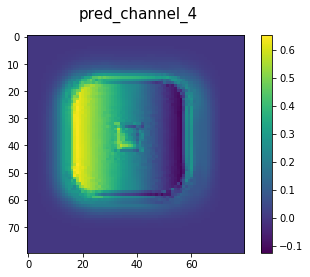

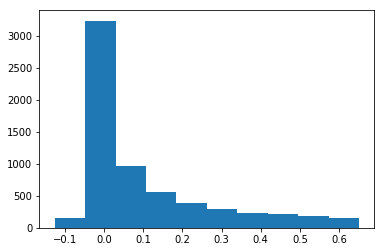

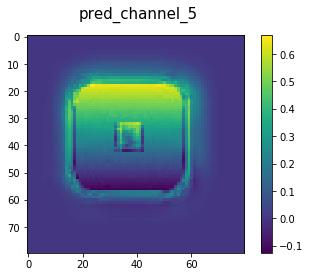

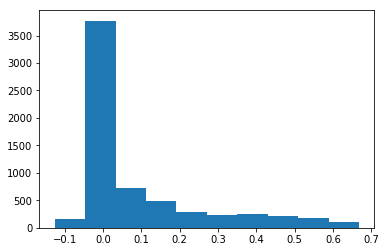

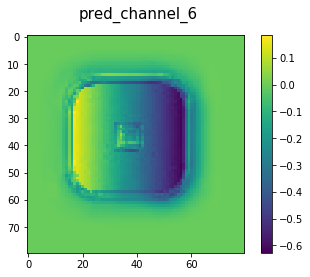

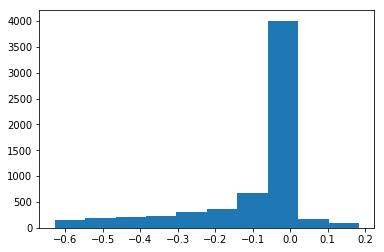

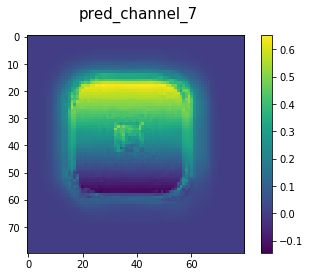

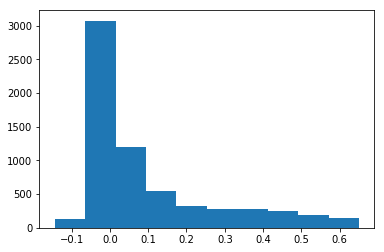

 46%|████▌     | 460/1000 [03:03<03:15,  2.76it/s]

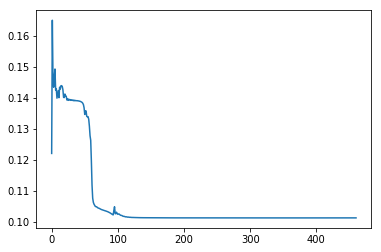

 47%|████▋     | 470/1000 [03:06<02:58,  2.97it/s]

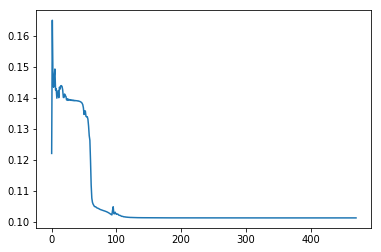

 48%|████▊     | 480/1000 [03:09<02:53,  3.00it/s]

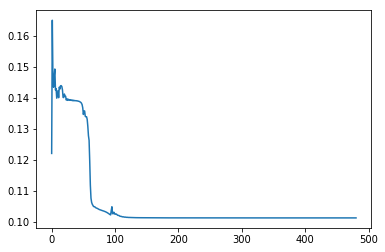

 49%|████▉     | 490/1000 [03:13<02:53,  2.94it/s]

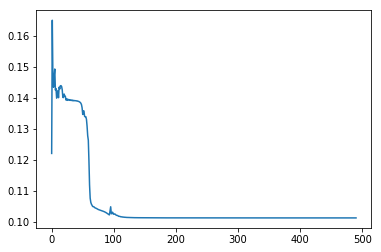

 50%|█████     | 500/1000 [03:16<02:48,  2.97it/s]

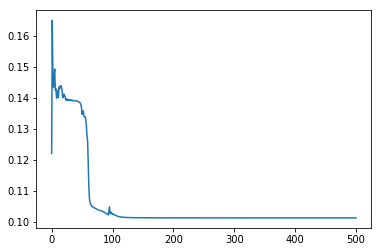

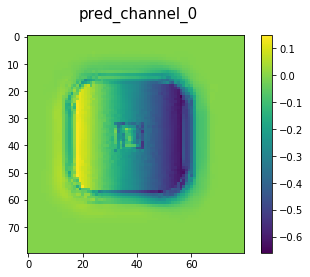

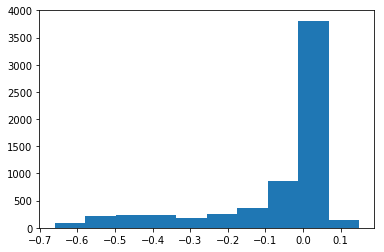

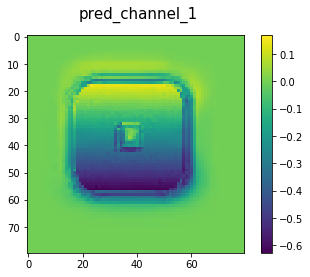

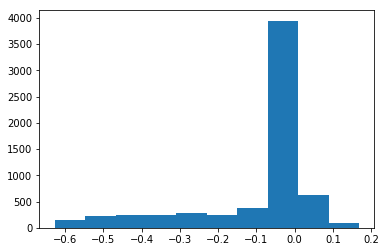

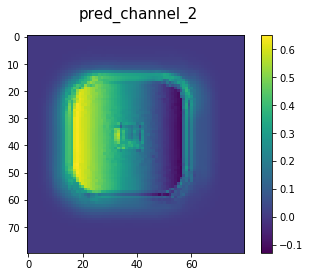

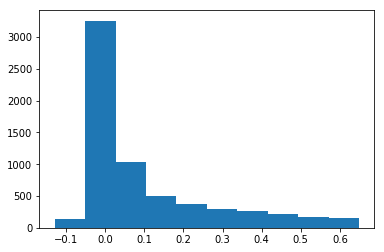

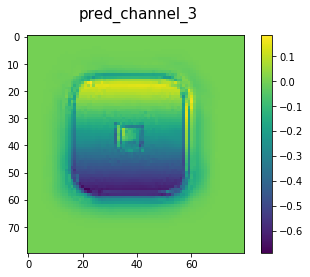

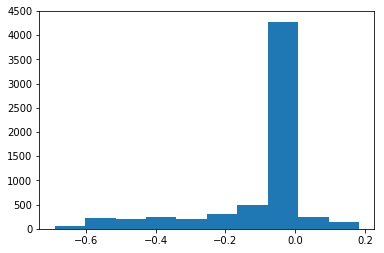

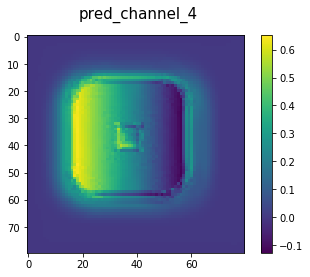

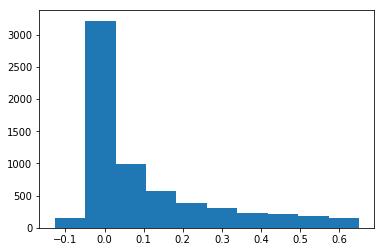

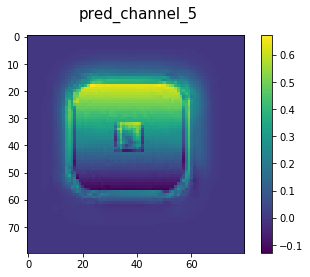

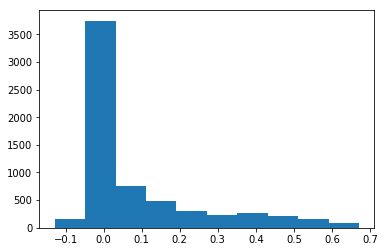

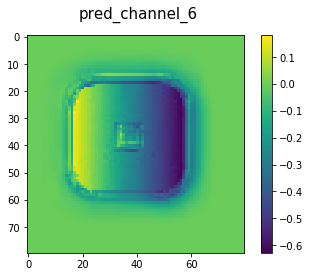

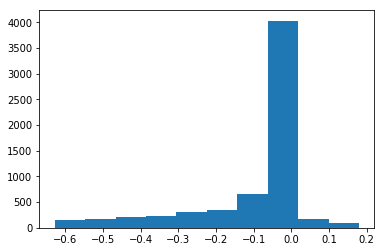

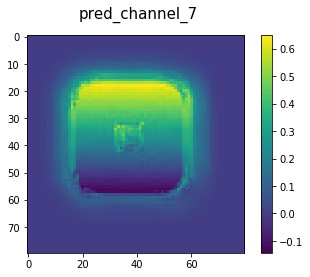

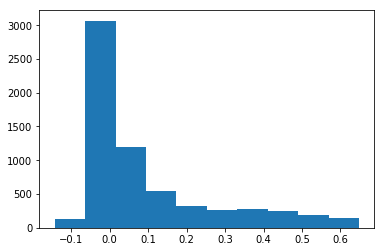

 51%|█████     | 510/1000 [03:23<03:16,  2.49it/s]

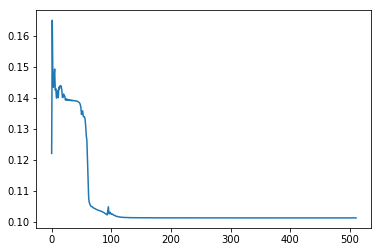

 52%|█████▏    | 518/1000 [03:26<02:43,  2.96it/s]

KeyboardInterrupt: 

In [19]:
from tqdm import tqdm
losses = []

plt.figure(figsize=(10,10))


# Training for loop
for i in tqdm(range(1000)):
    imgs, labels = db.generate_batch(n=3)
    
    # Hacky solution move this away
    imgs_c = np.moveaxis(imgs, -1, 1).astype(np.float32)
    labels_c = labels.reshape(labels.shape[0],1,8).astype(np.float32)
    
    # Downsample and encode
    imgs_down, labels_down = downsample(imgs_c, labels_c)
    gt_class, gt_loc = encode_y(imgs_down, labels_down)
    
    imgs_gpu = chainer.Variable(cuda.to_gpu(imgs_c)) #gpu
    
    gt_class, gt_loc = encode_y(imgs_down, labels_down) #cpu
    
    gt_class.to_gpu(0)
    gt_loc.to_gpu(0)

    # Forward pass: SLOW!!!
    pred_class, pred_loc = net(imgs_gpu) #net(imgs) #gpu
    
    
   # Loss calculation
#     class_loss = classification_loss(pred_class, gt_class)

    #net_loss = regression_loss(pred_loc, gt_loc, gt_class)
    
    
    net_loss = loss(pred_class, pred_loc, gt_class, gt_loc, lambd=1)
    #print(net_loss.debug_print())
    #net_loss.to_gpu(0)
    
    # Update network
    net.zerograds()
    net_loss.backward()
    optimizer.update()
    
    # Print loss
    #show_image(pred_class.data[0,0,:,:], 'prediction output vgg')
    #
    #show_image(gt_class.data[0,0,:,:], 'class output vgg')
    losses.append(net_loss.data.get())
    
    #print(net_loss.data)
    if i % 10 == 0:
        plt.plot(range(len(losses)), losses)
        plt.show()
        
    if i%50==0:
        for c in range(8):
            fig = plt.figure()
            fig.suptitle('pred_channel_%d'%c, fontsize=15)

            img = cuda.to_cpu(pred_loc[0,c,:,:].data)
            #print(img.)
            plt.imshow(img); plt.colorbar(); plt.show()
            plt.show()
            #img_c = np.zeros((320,320,3), dtype=np.uint8)

            #plt.imshow(img, interpolation=None); plt.colorbar(); plt.show()

            #draw_quad(img_c, labels[0][0].astype(np.uint64))
            #plt.imshow(img_c); plt.show()

            plt.hist(img.ravel()); plt.show()
    
# Final loss plot

In [ ]:
net(imgs_gpu)